In [ ]:
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import csv
from sklearn.metrics import jaccard_score
plt.style.use('ggplot')

* Introducción a los heroes, de que trata y a dota2.
* Explicar las variables que se usan.
* 10 heroes mas usados por perdedor.
* 10 heroes mas usados por regiones.
* Formamos una tabla por region, personaje que empleo y cuantas veces ganaron y perdieron en esa región.

Data Set Information:

Dota 2 is a popular computer game with two teams of 5 players. At the start of the game each player chooses a unique hero with different strengths and weaknesses. The dataset is reasonably sparse as only 10 of 113 possible heroes are chosen in a given game. All games were played in a space of 2 hours on the 13th of August, 2016

The data was collected using: [Web Link](https://gist.github.com/da-steve101/1a7ae319448db431715bd75391a66e1b)


Attribute Information:

Each row of the dataset is a single game with the following features (in the order in the vector):
1. Team won the game (1 or -1)
2. Cluster ID (related to location)
3. Game mode (eg All Pick)
4. Game type (eg. Ranked)
5. 5- end: Each element is an indicator for a hero. Value of 1 indicates that a player from team '1' played as that hero and '-1' for the other team. Hero can be selected by only one player each game. This means that each row has five '1' and five '-1' values.

The hero to id mapping can be found here: [Web Link](https://github.com/kronusme/dota2-api/blob/master/data/heroes.json)

In [1]:
cp drive/MyDrive/Colab_Notebooks/*.csv .

cp: cannot stat 'drive/MyDrive/Colab_Notebooks/*.csv': No such file or directory


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ls

ClusterID.csv   dota2Test.csv   drive/        GameType.csv  sample_data/
data_world.csv  dota2Train.csv  GameMode.csv  Heroes.csv


In [ ]:
df_Heroes=pd.read_csv('Heroes.csv') # files with ids of heroes
df_GameType=pd.read_csv('GameType.csv') 
df_ClusterID=pd.read_csv('ClusterID.csv')
df_GameMode=pd.read_csv('GameMode.csv')
#load the train data
df_dota_train=pd.read_csv('dota2Train.csv',header=None)
df_dota_test=pd.read_csv('dota2Test.csv',header=None)

In [ ]:
names_heroes=list(df_Heroes['name'])
features=['Winner','Region','Game_mode','Game_type']
df_dota_train.columns=features+names_heroes
df_dota_test.columns=features+names_heroes
df_dota_train2 = df_dota_train
df_dota_test2 = df_dota_test

In [ ]:
X_train = df_dota_train.iloc[:,4:]
X_test= df_dota_test.iloc[:,4:]
X_train.head()

In [ ]:
dict_winner={1:'Radiant',-1:'Dire'}
dict_GameType=dict(zip(df_GameType.to_dict()['id'].values(),df_GameType.to_dict()['name'].values()))
dict_GameMode=dict(zip(df_GameMode.to_dict()['id'].values(),df_GameMode.to_dict()['name'].values()))
dict_ClusterID=dict(zip(df_ClusterID.to_dict()['id'].values(),df_ClusterID.to_dict()['name'].values()))
df_dota_train['Winner']=df_dota_train['Winner'].map(dict_winner)
df_dota_train['Game_type']=df_dota_train['Game_type'].map(dict_GameType)
df_dota_train['Game_mode']=df_dota_train['Game_mode'].map(dict_GameMode)
df_dota_train['Region']=df_dota_train['Region'].map(dict_ClusterID)

df_dota_test['Winner']=df_dota_test['Winner'].map(dict_winner)
df_dota_test['Game_type']=df_dota_test['Game_type'].map(dict_GameType)
df_dota_test['Game_mode']=df_dota_test['Game_mode'].map(dict_GameMode)
df_dota_test['Region']=df_dota_test['Region'].map(dict_ClusterID)

In [ ]:
df_dota_train.head()

,Winner,Region,Game_mode,Game_type,antimage,axe,bane,bloodseeker,crystal_maiden,drow_ranger,earthshaker,juggernaut,mirana,nevermore,morphling,phantom_lancer,puck,pudge,razor,sand_king,storm_spirit,sven,tiny,vengefulspirit,windrunner,zuus,kunkka,None,lina,lich,lion,shadow_shaman,slardar,tidehunter,witch_doctor,riki,enigma,tinker,sniper,necrolyte,...,invoker,silencer,obsidian_destroyer,lycan,brewmaster,shadow_demon,lone_druid,chaos_knight,meepo,treant,ogre_magi,undying,rubick,disruptor,nyx_assassin,naga_siren,keeper_of_the_light,wisp,visage,slark,medusa,troll_warlord,centaur,magnataur,shredder,bristleback,tusk,skywrath_mage,abaddon,elder_titan,legion_commander,ember_spirit,earth_spirit,abyssal_underlord,terrorblade,phoenix,techies,oracle,winter_wyvern,arc_warden
0,Dire,China,Captains Mode,Tournament,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,-1,0,0,0,-1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,...,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Radiant,SoutheastAsia,Captains Mode,Tournament,0,0,0,1,0,-1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,-1,0,0,0,0,1,1,0,0,0,0,0,0,0,-1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Radiant,EuropeWest,Captains Mode,Tournament,0,0,0,1,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Radiant,SoutheastAsia,Captains Mode,Tournament,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0
4,Dire,Australia,Captains Mode,Tutorial,0,0,0,0,0,-1,0,0,-1,0,-1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Falta el heroe 24

In [ ]:
#La columna correspondiente al heroe 24. 
np.sum(np.abs(df_dota_train.iloc[:,27]))+np.sum(np.abs(df_dota_test.iloc[:,27]))

0

In [ ]:
#Heroes con cero selecciones.
for i in range(5,117):
    t=np.sum(np.abs(df_dota_train.iloc[:,i]))+np.sum(np.abs(df_dota_test.iloc[:,i]))
    if t==0:
        print(i)    

27
111


**Missing hero id 24**  
https://www.reddit.com/r/DotA2/comments/6jbspw/why_hero_with_id_24_doesnt_exist/  
https://liquipedia.net/dota2/MediaWiki:Dota2webapi-heroes.json

No hay valores para el heroe 24. En el archivo Heroes.csv se le asigno None,24,None.

### Formamos el vector de etiquetas a predecir.

In [ ]:
winners=list(df_dota_train['Winner'])
winners_test=list(df_dota_test['Winner'])

In [ ]:
#1 gano Radiant, 0 gano Dire
y=[1 if winner=='Radiant' else 0 for winner in winners]
y_test=[1 if winner=='Radiant' else 0 for winner in winners_test]

## Los 10 heroes mas usados

In [ ]:
#contamos las veces que aparece cada heroe
heroes_count={df_Heroes['localized_name'][h]:np.sum(np.abs(df_dota_train[df_dota_train.columns[h+4]])) for h in range(113)}
# ordenamos los heroes en forma descendente por 
sorted_heroes_count=dict(sorted(heroes_count.items(),key=lambda item:item[1],reverse=True))

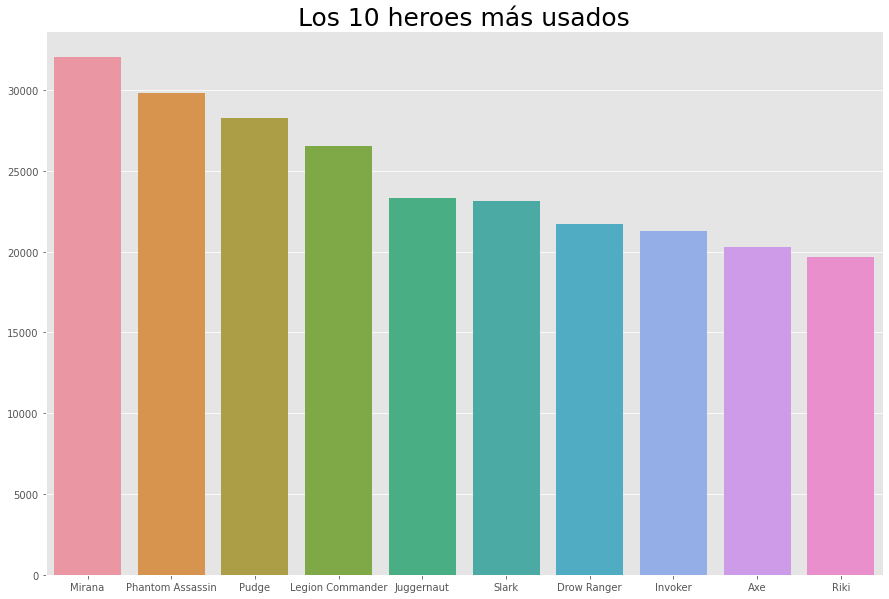

In [ ]:
#Graficamos los 10 heroes mas usados.
fig=plt.figure(figsize=(15,10))
sns.barplot(x=list(sorted_heroes_count.keys())[:10],y=list(sorted_heroes_count.values())[:10])
plt.title('Los 10 heroes más usados',size=25)
plt.show()

## 10 heroes más usados por el equipo Radiant.

In [ ]:
heroes_count_win={df_Heroes['localized_name'][h]:np.sum(df_dota_train[df_dota_train.iloc[:,h+4]==1].iloc[:,h+4]) for h in range(113)}
sorted_heroes_count_win=dict(sorted(heroes_count_win.items(),key=lambda item:item[1],reverse=True))

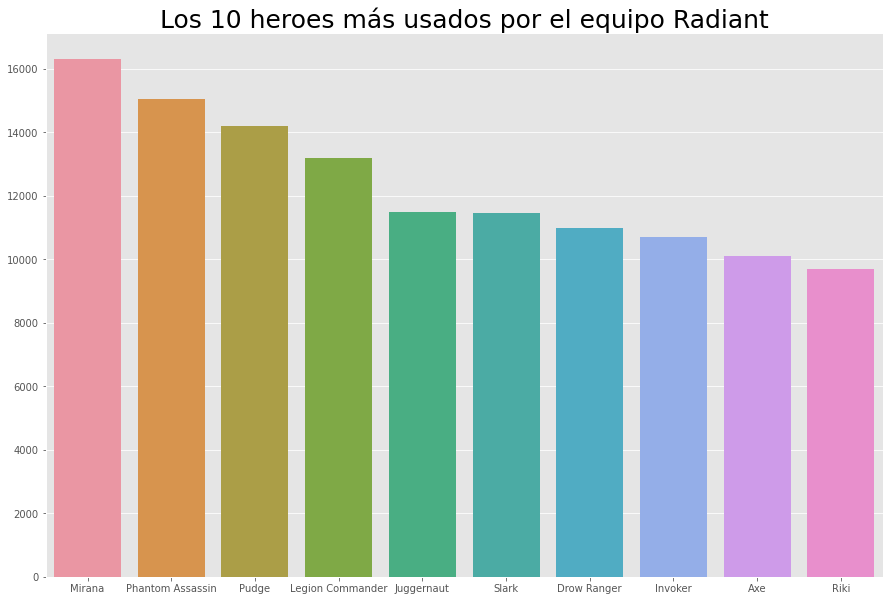

In [ ]:
#Graficamos los 10 heroes mas usados por el equipo Radiant
fig=plt.figure(figsize=(15,10))
sns.barplot(x=list(sorted_heroes_count_win.keys())[:10],y=list(sorted_heroes_count_win.values())[:10])
plt.title('Los 10 heroes más usados por el equipo Radiant',size=25)
plt.show()

## Los 10 heroes mas usados por el equipo Dire

In [ ]:
heroes_count_lose={df_Heroes['localized_name'][h]:np.abs(np.sum(df_dota_train[df_dota_train.iloc[:,h+4]==-1].iloc[:,h+4])) for h in range(113)}
sorted_heroes_count_lose=dict(sorted(heroes_count_lose.items(),key=lambda item:item[1],reverse=True))

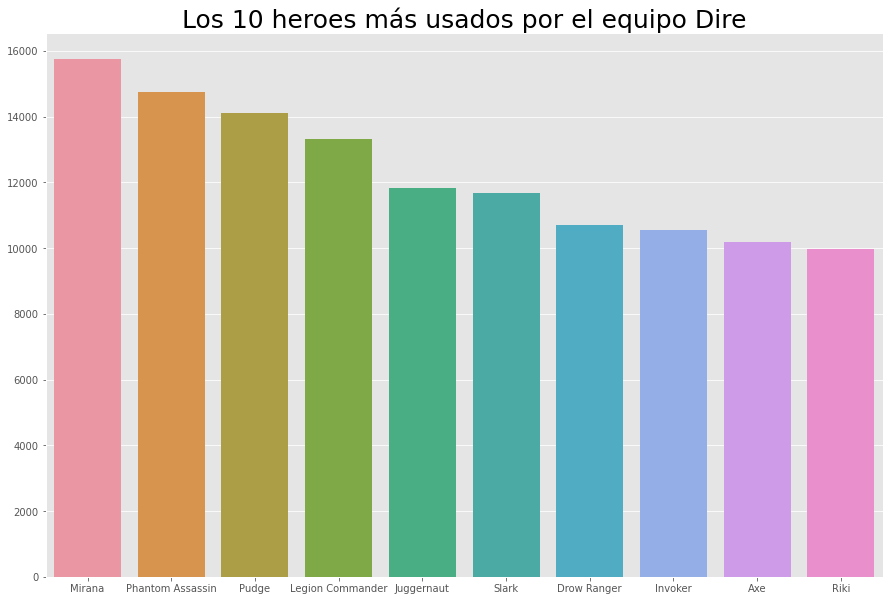

In [ ]:
#Graficamos los 10 heroes mas usados por el equipo Dire.
fig=plt.figure(figsize=(15,10))
sns.barplot(x=list(sorted_heroes_count_lose.keys())[:10],y=list(sorted_heroes_count_lose.values())[:10])
plt.title('Los 10 heroes más usados por el equipo Dire',size=25)
plt.show()

## Partidas por región

In [ ]:
#region_count={df_ClusterID['id'][h]:np.sum(df_dota_train[df_dota_train.iloc[:,1]==][1]) for h in range(113)}

## Victorias por región

## Realizamos one hot encoding de los datos.

In [ ]:
df_Dire=df_dota_train.iloc[:,4:]
df_Dire_train=df_dota_train2.iloc[:,4:]
df_Dire_test=df_dota_test2.iloc[:,4:]

In [ ]:
df_Dire

,antimage,axe,bane,bloodseeker,crystal_maiden,drow_ranger,earthshaker,juggernaut,mirana,nevermore,morphling,phantom_lancer,puck,pudge,razor,sand_king,storm_spirit,sven,tiny,vengefulspirit,windrunner,zuus,kunkka,None,lina,lich,lion,shadow_shaman,slardar,tidehunter,witch_doctor,riki,enigma,tinker,sniper,necrolyte,warlock,beastmaster,queenofpain,venomancer,...,invoker,silencer,obsidian_destroyer,lycan,brewmaster,shadow_demon,lone_druid,chaos_knight,meepo,treant,ogre_magi,undying,rubick,disruptor,nyx_assassin,naga_siren,keeper_of_the_light,wisp,visage,slark,medusa,troll_warlord,centaur,magnataur,shredder,bristleback,tusk,skywrath_mage,abaddon,elder_titan,legion_commander,ember_spirit,earth_spirit,abyssal_underlord,terrorblade,phoenix,techies,oracle,winter_wyvern,arc_warden
0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,-1,0,0,0,-1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,-1,0,0,...,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,-1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,-1,0,0,0,0,1,1,0,0,0,0,0,0,0,-1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,-1,0,0,-1,0,-1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92645,1,0,0,-1,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
92646,0,0,0,0,-1,0,0,-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
92647,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,-1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
92648,0,0,0,0,0,1,0,0,-1,0,0,-1,0,1,-1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_Dire.replace([1,-1],[0,1],inplace=True)
df_Dire_train.replace([1,-1],[0,1],inplace=True)
df_Dire_test.replace([1,-1],[0,1],inplace=True)

In [ ]:
df_Dire.columns=['Dire_'+name for name in names_heroes]
df_Dire_train.columns=['Dire_'+name for name in names_heroes]
df_Dire_test.columns=['Dire_'+name for name in names_heroes]

In [ ]:
df_Dire

,Dire_antimage,Dire_axe,Dire_bane,Dire_bloodseeker,Dire_crystal_maiden,Dire_drow_ranger,Dire_earthshaker,Dire_juggernaut,Dire_mirana,Dire_nevermore,Dire_morphling,Dire_phantom_lancer,Dire_puck,Dire_pudge,Dire_razor,Dire_sand_king,Dire_storm_spirit,Dire_sven,Dire_tiny,Dire_vengefulspirit,Dire_windrunner,Dire_zuus,Dire_kunkka,Dire_None,Dire_lina,Dire_lich,Dire_lion,Dire_shadow_shaman,Dire_slardar,Dire_tidehunter,Dire_witch_doctor,Dire_riki,Dire_enigma,Dire_tinker,Dire_sniper,Dire_necrolyte,Dire_warlock,Dire_beastmaster,Dire_queenofpain,Dire_venomancer,...,Dire_invoker,Dire_silencer,Dire_obsidian_destroyer,Dire_lycan,Dire_brewmaster,Dire_shadow_demon,Dire_lone_druid,Dire_chaos_knight,Dire_meepo,Dire_treant,Dire_ogre_magi,Dire_undying,Dire_rubick,Dire_disruptor,Dire_nyx_assassin,Dire_naga_siren,Dire_keeper_of_the_light,Dire_wisp,Dire_visage,Dire_slark,Dire_medusa,Dire_troll_warlord,Dire_centaur,Dire_magnataur,Dire_shredder,Dire_bristleback,Dire_tusk,Dire_skywrath_mage,Dire_abaddon,Dire_elder_titan,Dire_legion_commander,Dire_ember_spirit,Dire_earth_spirit,Dire_abyssal_underlord,Dire_terrorblade,Dire_phoenix,Dire_techies,Dire_oracle,Dire_winter_wyvern,Dire_arc_warden
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92645,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
92646,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
92647,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
92648,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_dota_train.columns=['Winner','Region','Game_mode','Game_type']+ ['Radiant_'+name for name in names_heroes]
df_dota_train2.columns=['Winner','Region','Game_mode','Game_type']+ ['Radiant_'+name for name in names_heroes]
df_dota_test2.columns=['Winner','Region','Game_mode','Game_type']+ ['Radiant_'+name for name in names_heroes]

In [ ]:
df_dota_train.replace(-1,0,inplace=True)
df_dota_train2.replace(-1,0,inplace=True)
df_dota_test2.replace(-1,0,inplace=True)

In [ ]:
df_dota_train=pd.concat([df_dota_train,df_Dire],axis=1)
df_dota_train2=pd.concat([df_dota_train2,df_Dire_train],axis=1)
df_dota_test2=pd.concat([df_dota_test2,df_Dire_test],axis=1)

In [ ]:
df_dota_train

,Winner,Region,Game_mode,Game_type,Radiant_antimage,Radiant_axe,Radiant_bane,Radiant_bloodseeker,Radiant_crystal_maiden,Radiant_drow_ranger,Radiant_earthshaker,Radiant_juggernaut,Radiant_mirana,Radiant_nevermore,Radiant_morphling,Radiant_phantom_lancer,Radiant_puck,Radiant_pudge,Radiant_razor,Radiant_sand_king,Radiant_storm_spirit,Radiant_sven,Radiant_tiny,Radiant_vengefulspirit,Radiant_windrunner,Radiant_zuus,Radiant_kunkka,Radiant_None,Radiant_lina,Radiant_lich,Radiant_lion,Radiant_shadow_shaman,Radiant_slardar,Radiant_tidehunter,Radiant_witch_doctor,Radiant_riki,Radiant_enigma,Radiant_tinker,Radiant_sniper,Radiant_necrolyte,...,Dire_invoker,Dire_silencer,Dire_obsidian_destroyer,Dire_lycan,Dire_brewmaster,Dire_shadow_demon,Dire_lone_druid,Dire_chaos_knight,Dire_meepo,Dire_treant,Dire_ogre_magi,Dire_undying,Dire_rubick,Dire_disruptor,Dire_nyx_assassin,Dire_naga_siren,Dire_keeper_of_the_light,Dire_wisp,Dire_visage,Dire_slark,Dire_medusa,Dire_troll_warlord,Dire_centaur,Dire_magnataur,Dire_shredder,Dire_bristleback,Dire_tusk,Dire_skywrath_mage,Dire_abaddon,Dire_elder_titan,Dire_legion_commander,Dire_ember_spirit,Dire_earth_spirit,Dire_abyssal_underlord,Dire_terrorblade,Dire_phoenix,Dire_techies,Dire_oracle,Dire_winter_wyvern,Dire_arc_warden
0,Dire,China,Captains Mode,Tournament,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Radiant,SoutheastAsia,Captains Mode,Tournament,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Radiant,EuropeWest,Captains Mode,Tournament,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Radiant,SoutheastAsia,Captains Mode,Tournament,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,Dire,Australia,Captains Mode,Tutorial,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92645,Dire,SoutheastAsia,Captains Mode,Tutorial,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
92646,Radiant,SoutheastAsia,Captains Mode,Tournament,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
92647,Radiant,USWest,Captains Mode,Tutorial,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
92648,Dire,Russia,Captains Mode,Tournament,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_dota_train.drop('Winner',axis=1,inplace=True)

In [ ]:
df_dota_train

,Region,Game_mode,Game_type,Radiant_antimage,Radiant_axe,Radiant_bane,Radiant_bloodseeker,Radiant_crystal_maiden,Radiant_drow_ranger,Radiant_earthshaker,Radiant_juggernaut,Radiant_mirana,Radiant_nevermore,Radiant_morphling,Radiant_phantom_lancer,Radiant_puck,Radiant_pudge,Radiant_razor,Radiant_sand_king,Radiant_storm_spirit,Radiant_sven,Radiant_tiny,Radiant_vengefulspirit,Radiant_windrunner,Radiant_zuus,Radiant_kunkka,Radiant_None,Radiant_lina,Radiant_lich,Radiant_lion,Radiant_shadow_shaman,Radiant_slardar,Radiant_tidehunter,Radiant_witch_doctor,Radiant_riki,Radiant_enigma,Radiant_tinker,Radiant_sniper,Radiant_necrolyte,Radiant_warlock,...,Dire_invoker,Dire_silencer,Dire_obsidian_destroyer,Dire_lycan,Dire_brewmaster,Dire_shadow_demon,Dire_lone_druid,Dire_chaos_knight,Dire_meepo,Dire_treant,Dire_ogre_magi,Dire_undying,Dire_rubick,Dire_disruptor,Dire_nyx_assassin,Dire_naga_siren,Dire_keeper_of_the_light,Dire_wisp,Dire_visage,Dire_slark,Dire_medusa,Dire_troll_warlord,Dire_centaur,Dire_magnataur,Dire_shredder,Dire_bristleback,Dire_tusk,Dire_skywrath_mage,Dire_abaddon,Dire_elder_titan,Dire_legion_commander,Dire_ember_spirit,Dire_earth_spirit,Dire_abyssal_underlord,Dire_terrorblade,Dire_phoenix,Dire_techies,Dire_oracle,Dire_winter_wyvern,Dire_arc_warden
0,China,Captains Mode,Tournament,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,SoutheastAsia,Captains Mode,Tournament,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,EuropeWest,Captains Mode,Tournament,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,SoutheastAsia,Captains Mode,Tournament,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,Australia,Captains Mode,Tutorial,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92645,SoutheastAsia,Captains Mode,Tutorial,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
92646,SoutheastAsia,Captains Mode,Tournament,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
92647,USWest,Captains Mode,Tutorial,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
92648,Russia,Captains Mode,Tournament,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Terminamos de realizar el one hot encoding

In [ ]:
df_train_onehot=pd.get_dummies(df_dota_train,prefix=features[1:],columns=features[1:])

In [ ]:
df_train_onehot

,Radiant_antimage,Radiant_axe,Radiant_bane,Radiant_bloodseeker,Radiant_crystal_maiden,Radiant_drow_ranger,Radiant_earthshaker,Radiant_juggernaut,Radiant_mirana,Radiant_nevermore,Radiant_morphling,Radiant_phantom_lancer,Radiant_puck,Radiant_pudge,Radiant_razor,Radiant_sand_king,Radiant_storm_spirit,Radiant_sven,Radiant_tiny,Radiant_vengefulspirit,Radiant_windrunner,Radiant_zuus,Radiant_kunkka,Radiant_None,Radiant_lina,Radiant_lich,Radiant_lion,Radiant_shadow_shaman,Radiant_slardar,Radiant_tidehunter,Radiant_witch_doctor,Radiant_riki,Radiant_enigma,Radiant_tinker,Radiant_sniper,Radiant_necrolyte,Radiant_warlock,Radiant_beastmaster,Radiant_queenofpain,Radiant_venomancer,...,Dire_tusk,Dire_skywrath_mage,Dire_abaddon,Dire_elder_titan,Dire_legion_commander,Dire_ember_spirit,Dire_earth_spirit,Dire_abyssal_underlord,Dire_terrorblade,Dire_phoenix,Dire_techies,Dire_oracle,Dire_winter_wyvern,Dire_arc_warden,Region_Australia,Region_Chile,Region_China,Region_EuropeEast,Region_EuropeWest,Region_India,Region_Peru,Region_Russia,Region_SouthAfrica,Region_SouthAmerica,Region_SouthKorea,Region_SoutheastAsia,Region_USEast,Region_USWest,Game_mode_?? INTRO/DEATH ??,Game_mode_All Pick,Game_mode_All Random,Game_mode_Captains Mode,Game_mode_Greeviling,Game_mode_Random Draft,Game_mode_Reverse Captains Mode,Game_mode_Single Draft,Game_mode_The Diretide,Game_type_Practice,Game_type_Tournament,Game_type_Tutorial
0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92645,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1
92646,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0
92647,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1
92648,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0


In [ ]:
X=df_train_onehot.to_numpy()[:10000]

In [ ]:
X.shape

(10000, 252)

In [ ]:
#con cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

cos_sim=cosine_similarity(X,X)

In [ ]:
from sklearn.manifold import MDS

In [ ]:
embed=MDS(n_components=2,dissimilarity='precomputed')

In [ ]:
X_transf=embed.fit_transform(cos_sim)

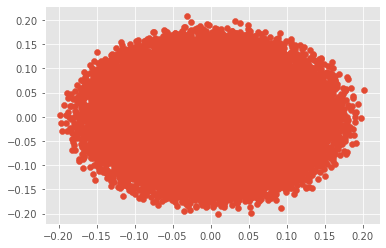

In [ ]:
plt.scatter(X_transf[:,0],X_transf[:,1])

## Calculamos la similaridad de Jacard

In [ ]:
(not [1,0,1]) and [0,0,1]

In [ ]:
x=[1,0,1]
np.sum([not e for e in x])

In [ ]:
a=np.array([[1,0],
            [0,0],
            [1,1]])
b=[0,1]

np.logical_and(a,b)

### Regresion Lineal
Primero se hara le baseline de realizar la regresion lineal para la combinacion lineal de los valores de seleccion de los heroes de cada equipo

In [ ]:
lr = LinearRegression()
regression = lr.fit(X, y)

print('w = ' + str(regression.coef_) + ', b = ' + str(regression.intercept_))


In [ ]:
prediccion = lr.predict(X_test)
y_pred = []
for i in range(len(prediccion)):
    y_pred.append(round(prediccion[i]))

lr.score(X, y)

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

print(confusion_matrix)
print(metrics.classification_report(y_test, y_pred))

####Regresion Lineal Multivariada
Ahora se toma en cuenta como dos variables distintas a cada heroe dependiendo del equipo que lo haya elegido, cumpliendo con las mismas condiciones anteriores y tomando en cuenta las variables categoricas.

In [ ]:
linear_regression = smf.ols(formula = 'Winner ~ C(Region) + C(Game_mode) + C(Game_type) + Dire_antimage + Dire_axe + Dire_bane + Dire_bloodseeker + Dire_crystal_maiden + Dire_drow_ranger + Dire_earthshaker + ',
                            ' Dire_juggernaut + Dire_mirana + Dire_nevermore + Dire_morphling + Dire_phantom_lancer + Dire_puck + Dire_pudge + Dire_razor + Dire_sand_king + Dire_storm_spirit + Dire_sven + ',
                            ' Dire_tiny + Dire_vengefulspirit + Dire_windrunner + Dire_zuus + Dire_kunkka + Dire_None + Dire_lina + Dire_lich + Dire_lion + Dire_shadow_shaman + Dire_slardar + Dire_tidehunter + ',
                            ' Dire_witch_doctor + Dire_riki + Dire_enigma + Dire_tinker + Dire_sniper + Dire_necrolyte + Dire_warlock + Dire_beastmaster + Dire_queenofpain + Dire_venomancer + Dire_faceless_void +',
                            ' Dire_skeleton_king + Dire_death_prophet + Dire_phantom_assassin + Dire_pugna + Dire_templar_assassin + Dire_viper + Dire_luna + Dire_dragon_knight + Dire_dazzle + Dire_rattletrap + ',
                            ' Dire_leshrac + Dire_furion + Dire_life_stealer + Dire_dark_seer + Dire_clinkz + Dire_omniknight + Dire_enchantress + Dire_huskar + Dire_night_stalker + Dire_broodmother + ',
                            ' Dire_bounty_hunter + Dire_weaver + Dire_jakiro + Dire_batrider + Dire_chen + Dire_spectre + Dire_doom_bringer + Dire_ancient_apparition + Dire_ursa + Dire_spirit_breaker + ', 
                            ' Dire_gyrocopter + Dire_alchemist + Dire_invoker + Dire_silencer + Dire_obsidian_destroyer + Dire_lycan + Dire_brewmaster + Dire_shadow_demon + Dire_lone_druid + Dire_chaos_knight + ', 
                            ' Dire_meepo + Dire_treant + Dire_ogre_magi + Dire_undying + Dire_rubick + Dire_disruptor + Dire_nyx_assassin + Dire_naga_siren + Dire_keeper_of_the_light + Dire_wisp + Dire_visage + ',
                            ' Dire_slark + Dire_medusa + Dire_troll_warlord + Dire_centaur + Dire_magnataur + Dire_shredder + Dire_bristleback + Dire_tusk + Dire_skywrath_mage + Dire_abaddon + Dire_elder_titan + ',
                            ' Dire_legion_commander + Dire_ember_spirit + Dire_earth_spirit + Dire_abyssal_underlord + Dire_terrorblade + Dire_phoenix + Dire_techies + Dire_oracle + Dire_winter_wyvern + ',
                            ' Dire_arc_warden + Radiant_antimage + Radiant_axe + Radiant_bane + Radiant_bloodseeker + Radiant_crystal_maiden + Radiant_drow_ranger + Radiant_earthshaker + Radiant_juggernaut + ',
                            ' Radiant_mirana + Radiant_nevermore + Radiant_morphling + Radiant_phantom_lancer + Radiant_puck + Radiant_pudge + Radiant_razor + Radiant_sand_king + Radiant_storm_spirit + Radiant_sven + ',
                            ' Radiant_tiny + Radiant_vengefulspirit + Radiant_windrunner + Radiant_zuus + Radiant_kunkka + Radiant_None + Radiant_lina + Radiant_lich + Radiant_lion + Radiant_shadow_shaman + Radiant_slardar + ', 
                            ' Radiant_tidehunter + Radiant_witch_doctor + Radiant_riki + Radiant_enigma + Radiant_tinker + Radiant_sniper + Radiant_necrolyte + Radiant_warlock + Radiant_beastmaster + Radiant_queenofpain + ',
                            ' Radiant_venomancer + Radiant_faceless_void + Radiant_skeleton_king + Radiant_death_prophet + Radiant_phantom_assassin + Radiant_pugna + Radiant_templar_assassin + Radiant_viper + Radiant_luna + ', 
                            ' Radiant_dragon_knight + Radiant_dazzle + Radiant_rattletrap + Radiant_leshrac + Radiant_furion + Radiant_life_stealer + Radiant_dark_seer + Radiant_clinkz + Radiant_omniknight + ', 
                            ' Radiant_enchantress + Radiant_huskar + Radiant_night_stalker + Radiant_broodmother + Radiant_bounty_hunter + Radiant_weaver + Radiant_jakiro + Radiant_batrider + Radiant_chen + ', 
                            ' Radiant_spectre + Radiant_doom_bringer + Radiant_ancient_apparition + Radiant_ursa + Radiant_spirit_breaker + Radiant_gyrocopter + Radiant_alchemist + Radiant_invoker + Radiant_silencer + ', 
                            ' Radiant_obsidian_destroyer + Radiant_lycan + Radiant_brewmaster + Radiant_shadow_demon + Radiant_lone_druid + Radiant_chaos_knight + Radiant_meepo + Radiant_treant + Radiant_ogre_magi + ', 
                            ' Radiant_undying + Radiant_rubick + Radiant_disruptor + Radiant_nyx_assassin + Radiant_naga_siren + Radiant_keeper_of_the_light + Radiant_wisp + Radiant_visage + Radiant_slark + Radiant_medusa + ', 
                            ' Radiant_troll_warlord + Radiant_centaur + Radiant_magnataur + Radiant_shredder + Radiant_bristleback + Radiant_tusk + Radiant_skywrath_mage + Radiant_abaddon + Radiant_elder_titan + ', 
                            ' Radiant_legion_commander + Radiant_ember_spirit + Radiant_earth_spirit + Radiant_abyssal_underlord + Radiant_terrorblade + Radiant_phoenix + Radiant_techies + Radiant_oracle + ', 
                            ' Radiant_winter_wyvern + Radiant_arc_warden', data=df_dota_train2)

mod = linear_regression.fit()

In [ ]:
print(mod.summary())

In [ ]:
X_test = df_dota_test2.iloc[:,1:]
ypred = mod.predict(X_test)
y_pred = []
for i in range(len(ypred)):
    y_pred.append(round(ypred[i]))

confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
print(confusion_matrix)

In [ ]:
print(metrics.classification_report(y_test, y_pred))

Regresion Lineal sin contar variables categoricas

In [ ]:
X_train = df_dota_train2.iloc[:,4:]
lr = LinearRegression()
regression = lr.fit(X_train, y)
print('w = ' + str(regression.coef_) + ', b = ' + str(regression.intercept_))


In [ ]:
X_test = df_dota_test2.iloc[:,4:]
prediccion = lr.predict(X_test)
y_pred = []
for i in range(len(prediccion)):
    y_pred.append(round(prediccion[i]))

lr.score(X_train, y)

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

print(confusion_matrix)

In [ ]:
print(metrics.classification_report(y_test, y_pred))

## Regresion Logistica
Se realizara ahora la regresion logistica para agrupar los datos sin utilizar las variables categoricas

In [ ]:
logreg.fit(X_train, y)

In [ ]:
logreg = LogisticRegression(solver='newton-cg', C = 1e9)
result = logreg.fit(X_train, y)
logreg.fit(X_train, y)

In [ ]:
print(np.round(logreg.coef_,4),np.round(logreg.intercept_,4))

In [ ]:
y_pred = logreg.predict(X_test)

print('Precision del clasificador por medio de regresion logistica: {:.2f}'.format(logreg.score(X_test, y_test)))

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
print(confusion_matrix)

In [ ]:
print(metrics.classification_report(y_test, y_pred))